In [ ]:
from __future__ import division
%pylab inline
import pandas as pd
import os
import json
from collections import defaultdict, Counter
%load_ext autoreload
%autoreload 2

In [2]:
df_all = pd.read_pickle('output/df_sites.pkl')
df_asn_cdn = pd.read_pickle('output/df_asn_cdn.pkl')

rank_to_site = df_all.set_index('rank')['site'].to_dict()

In [3]:
from calculate_timings import calculate_sizes, calculate_timings 

# messed up timings due to redirection - don't work with this directly
df_data1 = pd.read_json("output/curl-timing-data-reorder-count100-sites500.json")
# timing data no redirects
df_data2 = pd.read_json("output/curl-timing-data-no_redirects-count100-sites500.json")
# timing data no redirects + sleep(10)
df_data3 = pd.read_json("output/curl-timing-data-no_redirects-delay10-count100-sites500.json")


In [4]:
df_timing1 = calculate_timings(df_data1)
df_timing2 = calculate_timings(df_data2)
df_timing3 = calculate_timings(df_data3)

In [5]:
# check if time_redirect > 0
print( len(df_timing1[ df_timing1['time_redirect'] > 0 ]))
print( len(df_timing2[ df_timing2['time_redirect'] > 0 ]))
print( len(df_timing3[ df_timing3['time_redirect'] > 0 ]))

16583
0
0


In [64]:
# check any negative values
d = df_timing2
for cols in d.columns.tolist()[1:]:
    if cols[0]=='t' and cols !='timestamp':
        print(cols, len(d[d[cols]<0]))

time_redirect 0
time_namelookup 0
time_connect 0
time_appconnect 0
time_pretransfer 0
time_starttransfer 0
time_total 0
t_dns 0
t_tcp 2114
t_ssl 0
t_calc 0
t_wait 184
t_fbyte 0
t_rx 0


In [7]:
df_timing1[(df_timing1['t_wait']<0) & (df_timing1['response_code']==200)]

,response_code,size_download,size_header,size_request,size_upload,url_effective,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,time_total,rank,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx


In [8]:
df_timing2[(df_timing2['t_wait']<0) & (df_timing2['response_code']!=0)]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,rank,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx


In [9]:
df_timing3[(df_timing3['t_wait']<0) & (df_timing3['response_code']!=0)]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,rank,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx


# Clean up
- 50000 requests:
    - 7098 failed with response code 0, 42902 passed
    - 23898 directly gave webpage (response_code 200)
    - 16090 redirect with 301/302 (permanent and temporary redirect) 7k+ each
    - 2266 forbidden and could not be fulfilled possibly due to too many requests detected from our IP/script
    - 648 unavailable service maybe due to bad proxy

In [10]:
df_fail = df_timing2[df_timing2['response_code'] == 0]
df_pass = df_timing2[df_timing2['response_code']!=0]

In [11]:
len(df_fail), len(df_pass)

(7098, 42902)

In [12]:
df_pass.groupby('response_code')['rank'].count()

response_code
200    23898
301     7693
302     7923
303       96
307      378
403     1528
404      667
429       71
500       95
502       18
503      535
Name: rank, dtype: int64

In [13]:
print(7693 + 7923 + 96 + 378)
print(1528 + 667 + 71)
print(535 + 18 + 95)

16090
2266
648


## quick check
- t_fbyte
- t_calc at client

In [14]:
df_pass[ df_pass['t_fbyte'] <= (df_pass['t_dns'] + df_pass['t_tcp'] + df_pass['t_ssl'] + df_pass['t_wait'] ) ]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,rank,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx


In [18]:
fbyte_check = ( df_pass['t_fbyte'] - (df_pass['t_dns'] + df_pass['t_tcp'] + df_pass['t_ssl'] + df_pass['t_wait'] + df_pass['t_calc']) )
fbyte_check.describe()

count    4.290200e+04
mean     4.170420e-19
std      8.472204e-17
min     -1.776357e-15
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.776357e-15
dtype: float64

In [24]:
( df_pass['time_pretransfer'] - ( df_pass["t_ssl"] + df_pass["t_tcp"]  + df_pass["t_dns"]) ).describe()

count    42902.000000
mean         0.000081
std          0.000042
min          0.000020
25%          0.000040
50%          0.000082
75%          0.000102
max          0.000626
dtype: float64

In [25]:
df_pass[ df_pass['time_total'] <= (df_pass['t_dns'] + df_pass['t_tcp'] + df_pass['t_ssl'] + df_pass['t_wait'] + df_pass['t_rx'] ) ]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,rank,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx


In [26]:
t_calc = df_pass['time_pretransfer'] - df_pass['time_appconnect']
t_calc.describe()

count    42902.000000
mean         0.000081
std          0.000042
min          0.000020
25%          0.000040
50%          0.000082
75%          0.000102
max          0.000626
dtype: float64

### Google.* redirect behavior
- Only about first 20 requests have a 200 response for all google.* domains
- Suddenly all start redirecting to manual check page
- network reset occurs impacting all sites and we get a few more 200's in before page 302s again
- only impact google.* domains not youtube etc. that are also on the same ASN 

In [27]:
google = df_timing2[df_timing2['rank']==1]
youtube = df_timing2[df_timing2['rank']==2]
facebook = df_timing2[df_timing2['rank']==3]
googlein = df_timing2[df_timing2['rank']==12]

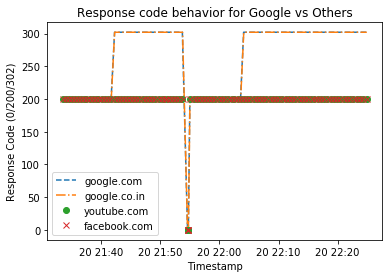

In [28]:
f,ax = subplots()
ax.plot( pd.to_datetime(google.timestamp), google['response_code'], label='google.com', linestyle='--')
ax.plot( pd.to_datetime(googlein.timestamp), googlein['response_code'], label='google.co.in', linestyle='-.')
ax.plot( pd.to_datetime(youtube.timestamp), youtube['response_code'], label='youtube.com', marker='o', linestyle='None')
ax.plot( pd.to_datetime(facebook.timestamp), facebook['response_code'], label='facebook.com', marker ='x', linestyle='None')
ax.legend(loc='best')
ax.set_title("Response code behavior for Google vs Others")
ax.set_xlabel('Timestamp')
ax.set_ylabel("Response Code (0/200/302)")
f.savefig('results/google_vs_others_response_code')


### Failure rate per domain
- 49 sites completely failed, i.e. all responses were 0, no data was downloaded
- 18 of 49 sites are those that were blocked by ISP and we could not get their host IP address. This includes porn related websites and some adware/malware domains.
- Of 31 sites, the chinese ones could be reached via browser (\*.tmall.com, china.com.cn). Certain domains were completely unaccessible (redd.it, twimg.com, cloudfront.net) possibly because they are servers catering to specific IPs/ports only. Certain others (bodelen.com, resentaticexhaus.info) are redirect viruses that send you to your browser's home page.
- After removing the 49 sites, we are left with 45100 requests of which only 2198 failed around the same time (around loop 40 of 100 requests/site). This may be due to a network failure, or a reset at the ISP. 
- Of all other 451 sites, only 1 site (rank 368 'youdao.com') received status code 0 for 72 requests. So we can use only 28 requests to estimate timings. All other sites had responses for more than 60 requests each.

In [29]:
df_timing2['fail']= df_timing2['response_code']==0

In [30]:
df_temp = df_timing2.groupby(['rank', 'fail'])['response_code'].count().reset_index()
df_total_responses = df_temp.pivot(index='rank', columns='fail', values='response_code').fillna(0).reset_index()
df_total_responses['site'] = df_total_responses['rank'].map(rank_to_site)

In [31]:
df_all_fail = df_total_responses[ df_total_responses[False]==0 ]
print(len(df_all_fail))

49


In [32]:
df_filtered = df_timing2[ ~df_timing2['rank'].isin(df_all_fail['rank']) ]

print(len(df_filtered))
print(len(df_filtered['rank'].unique()))

df_filtered.groupby('response_code')['rank'].count()

45100
451


response_code
0       2198
200    23898
301     7693
302     7923
303       96
307      378
403     1528
404      667
429       71
500       95
502       18
503      535
Name: rank, dtype: int64

Total responses with status code 0 (Failed) =  2198
Total responses with status code 200 (OK) =  23898
Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) =  19004
Overall success rate = 0.5298891352549889


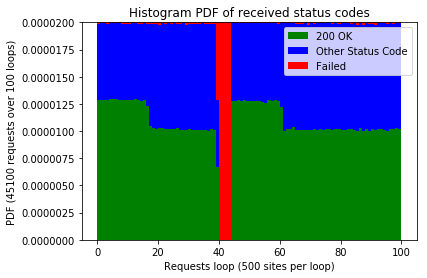

In [33]:
data0 = [int(d) for d in df_filtered[(df_filtered['response_code']==0)]['response_code'].index ]
#x0,y0 = getCDF(data0)
data200 = [int(d) for d in df_filtered[(df_filtered['response_code']==200)]['response_code'].index ]
#x200,y200 = getCDF(data200)
dataother = [int(d) for d in df_filtered[~(df_filtered['response_code'].isin([0,200]))]['response_code'].index ]
#xother,yother = getCDF(dataother)

print("Total responses with status code 0 (Failed) = ", len(data0))
print("Total responses with status code 200 (OK) = ", len(data200))
print("Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) = ", len(dataother))
print("Overall success rate = %s" %(len(data200)/len(df_filtered)))

f,ax = subplots()
ax.hist([data200,dataother,data0], 100, color=["green", "blue","red"], density = True, stacked=True)
ax.legend({'200 OK': "green", 'Other Status Code': "blue", 'Failed': "red"})
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Histogram PDF of received status codes")
ax.set_xlabel("Requests loop (500 sites per loop)")
ax.set_ylabel("PDF (45100 requests over 100 loops)")
f.savefig("results/curl_requests_filtered_status_code_pdf_hist")

### Quick check of ssl flag (in case time_appconnect = 0)

In [34]:
df_pass = df_filtered[df_filtered['response_code']!=0]

df_pass[ df_pass['ssl_flag']==False ]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx,fail


In [35]:
df_filtered[ (df_filtered['ssl_flag']==False) & (df_filtered['response_code']!=0) ]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx,fail


In [36]:
df_pass[df_pass['time_appconnect']==0]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx,fail


In [37]:
df_pass[df_pass['time_appconnect']<df_pass['time_connect']]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx,fail


### we are not using redirect flag (curl -L)

In [38]:
df_pass[ df_pass['time_redirect']>0 ]

,response_code,size_request,size_upload,size_download,size_header,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,...,timestamp,t_dns,t_tcp,t_ssl,ssl_flag,t_calc,t_wait,t_fbyte,t_rx,fail


# Analyze df_passed
- remove all failures
- An overall avg across all 42902 valid responses shows:
    - 1.03s total load time (this includes sites that fully loaded with 200 OK response, and sites that were forbidden or redirected us). This does not include following redirection to the correct page (as seen on browsers).
    - overall average size downloaded is around 102 KB, while overall reception time is .25s, making the approx avg download speed for webpages ~3.25 Mbps. 
    - overall dns resolution and tcp handshake are quite fast (0.8s, 0.95s), but ssl negotiation takes 0.24s on avg.
    - overall average waiting time is surprisingly 0.37s, making it a major contribution to the total time. Even removing tcp handshake time (0.09s) from this implies that the server genuinely waits for around 0.3s on average across all valid responses.

In [60]:
df_pass = df_filtered[df_filtered['response_code']!=0]

check = df_pass.groupby('rank')['response_code'].count()
check[ check<60 ]

rank
368    28
Name: response_code, dtype: int64

In [61]:
df_pass.columns

Index(['response_code', 'size_request', 'size_upload', 'size_download',
       'size_header', 'time_redirect', 'time_namelookup', 'time_connect',
       'time_appconnect', 'time_pretransfer', 'time_starttransfer',
       'time_total', 'rank', 'timestamp', 't_dns', 't_tcp', 't_ssl',
       'ssl_flag', 't_calc', 't_wait', 't_fbyte', 't_rx', 'fail'],
      dtype='object')

### Quick average of avg across sites

In [200]:
print(len(df_pass))

42902


In [202]:
#df_pass.groupby('rank').mean().mean()  # each site contributes once after grouping instead of overall avg

df_pass.mean()

response_code            253.471283
size_request              77.621696
size_upload                0.000000
size_download         101541.676169
size_header              704.455596
time_redirect              0.000000
time_namelookup            0.080428
time_connect               0.175490
time_appconnect            0.415621
time_pretransfer           0.415702
time_starttransfer         0.786753
time_total                 1.033064
rank                     251.395902
t_dns                      0.080428
t_tcp                      0.095061
t_ssl                      0.240131
ssl_flag                   1.000000
t_calc                     0.000081
t_wait                     0.371051
t_fbyte                    0.786753
t_rx                       0.246311
fail                       0.000000
dtype: float64

# Time info

In [65]:
time_cols = ['time_redirect', 'time_namelookup', 'time_connect',
       'time_appconnect', 'time_pretransfer', 'time_starttransfer',
       'time_total']
t_cols = ['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx', 't_fbyte']

df_avg_time = df_pass.groupby(['rank'])[time_cols+t_cols].mean()

In [66]:
df_avg_time.describe()

,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,451.0,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000
mean,0.0,0.080792,0.176625,0.418919,0.419000,0.801196,1.046710,0.080792,0.095833,0.242294,0.000081,0.382196,0.245514,0.801196
std,0.0,0.184207,0.220120,0.401601,0.401590,0.770926,1.026677,0.184207,0.102714,0.240350,0.000033,0.658629,0.550331,0.770926
min,0.0,0.004685,0.009554,0.033102,0.033191,0.036577,0.036586,0.004685,0.002588,0.019038,0.000029,0.003363,0.000009,0.036577
25%,0.0,0.012776,0.036704,0.112098,0.112204,0.435217,0.442599,0.012776,0.003560,0.072397,0.000037,0.170302,0.000085,0.435217
50%,0.0,0.024512,0.101711,0.279313,0.279412,0.650975,0.770523,0.024512,0.036027,0.118275,0.000097,0.315868,0.002943,0.650975
75%,0.0,0.053229,0.237762,0.605351,0.605477,0.996263,1.337812,0.053229,0.161303,0.347192,0.000105,0.403037,0.258839,0.996263
max,0.0,1.555392,1.558288,2.289830,2.289867,8.597790,8.598477,1.555392,0.400465,1.634377,0.000151,8.469223,5.918629,8.597790


In [67]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

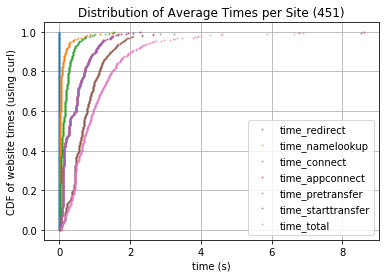

In [71]:
f, ax = subplots()

for col in time_cols:
    xd, yd = getCDF(df_avg_time[col])
    ax.plot(xd, yd, label=col, marker='.', alpha=.5, markersize=2, linestyle='None')
    
ax.grid(True)
ax.legend(loc='best')
ax.set_xlabel("time (s)")
ax.set_ylabel("CDF of website times (using curl)")
ax.set_title("Distribution of Average Times per Site (451)")
f.savefig("results/cdf_avg_time_curl")

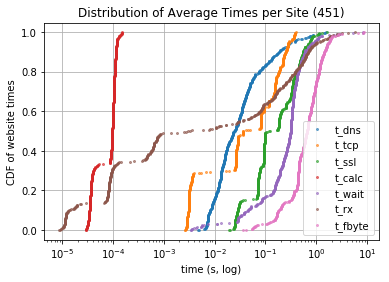

In [72]:
f, ax = subplots()

for col in t_cols:
    xd, yd = getCDF(df_avg_time[col])
    ax.semilogx(xd, yd, label=col, marker='o', markersize=2, alpha=.6, linestyle='None')
    
ax.grid(True)
ax.legend(loc='best')
ax.set_xlabel("time (s, log)")
ax.set_ylabel("CDF of website times")
ax.set_title("Distribution of Average Times per Site (451)")
f.savefig("results/cdf_avg_time_diff_calculated")

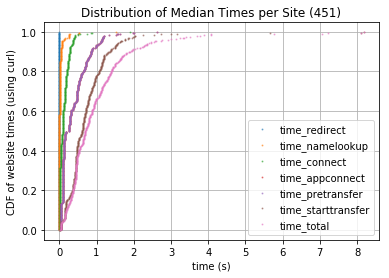

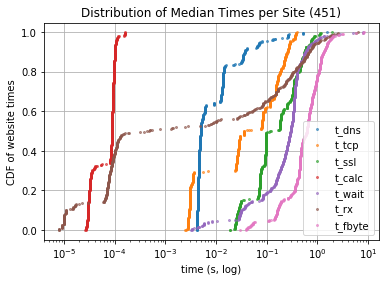

In [75]:
df_median_time = df_pass.groupby(['rank'])[t_cols+time_cols].median()
f, ax = subplots()
for col in time_cols:
    xd, yd = getCDF(df_median_time[col])
    ax.plot(xd, yd, label=col, marker='.', alpha=.5, markersize=2, linestyle="None")
ax.grid(True)
ax.legend(loc='best')
ax.set_xlabel("time (s)")
ax.set_ylabel("CDF of website times (using curl)")
ax.set_title("Distribution of Median Times per Site (451)")
f.savefig("results/cdf_median_time_curl")

f, ax = subplots()
for col in t_cols:
    xd, yd = getCDF(df_median_time[col])
    ax.semilogx(xd, yd, label=col, marker='o', markersize=2, alpha=.6, linestyle='None') 
ax.grid(True)
ax.legend(loc='best')
ax.set_xlabel("time (s, log)")
ax.set_ylabel("CDF of website times")
ax.set_title("Distribution of Median Times per Site (451)")
f.savefig("results/cdf_median_time_diff_calculated")

## find std of columns
- rank 51 has very high std values
- rank 232 has very large std in total_time
- rank 116 has very large std in starttransfer

df_pass.groupby(['rank'])[cols].std().idxmax()

In [76]:
df_pass.groupby(['rank'])[time_cols+t_cols].std().loc[51]

time_redirect         0.000000
time_namelookup       1.713474
time_connect          1.713653
time_appconnect       1.714092
time_pretransfer      1.714095
time_starttransfer    1.713967
time_total            1.723406
t_dns                 1.713474
t_tcp                 0.000756
t_ssl                 0.002294
t_calc                0.000026
t_wait                0.017341
t_rx                  0.059881
t_fbyte               1.713967
Name: 51, dtype: float64

In [77]:
df_pass.groupby(['rank'])[time_cols+t_cols].std().loc[116]

time_redirect         0.000000
time_namelookup       1.707225
time_connect          1.707266
time_appconnect       1.707463
time_pretransfer      1.707463
time_starttransfer    1.763179
time_total            1.765060
t_dns                 1.707225
t_tcp                 0.000384
t_ssl                 0.002269
t_calc                0.000006
t_wait                0.250384
t_rx                  0.027992
t_fbyte               1.763179
Name: 116, dtype: float64

In [78]:
df_pass.groupby(['rank'])[time_cols+t_cols].std().loc[232]

time_redirect         0.000000
time_namelookup       0.239499
time_connect          0.239253
time_appconnect       0.239677
time_pretransfer      0.239680
time_starttransfer    0.256667
time_total            3.456811
t_dns                 0.239499
t_tcp                 0.005778
t_ssl                 0.011885
t_calc                0.000030
t_wait                0.070943
t_rx                  3.450482
t_fbyte               0.256667
Name: 232, dtype: float64

['naver.com', 'rakuten.co.jp', 'kompas.com']


Text(0.5, 1.0, 'response code')

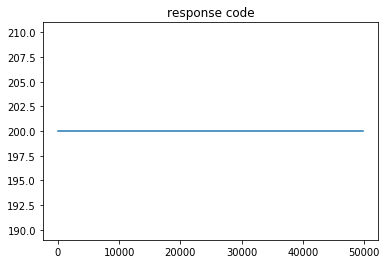

In [79]:
print([rank_to_site[r] for r in [51,116,232]])

plot( df_pass[ df_pass['rank'].isin([51,116,232]) ]['response_code'] )
title('response code')

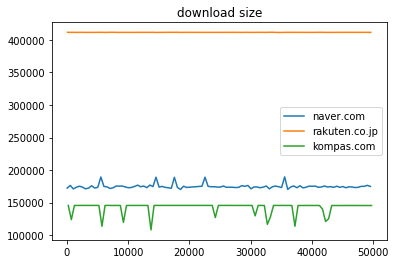

In [80]:
temp = df_pass[ df_pass['rank'].isin([51,116,232]) ][['rank','size_download']].groupby('rank')

for i, val in temp:
    plot(val['size_download'], label=rank_to_site[i])
title('download size')
legend(loc='best')

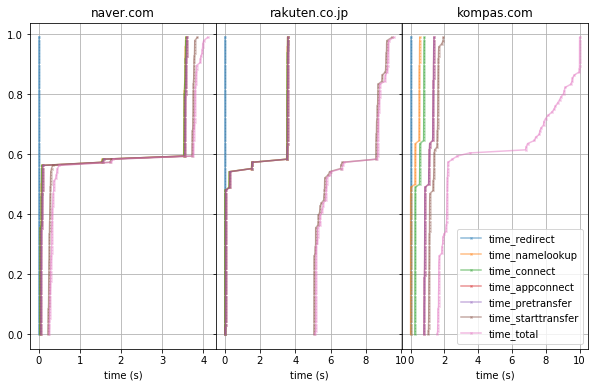

In [83]:
f, axarr = subplots(1,3, sharey=True, figsize=(10,6))
i = 0
for rank in [51, 116, 232]:
    df_observe = df_pass[ df_pass['rank']==rank ]
    for col in time_cols:
        xd, yd = getCDF(df_observe[col])
        axarr[i].plot(xd, yd, label=col, marker='x', alpha=.5, markersize=2)
    axarr[i].grid(True)
    #
    axarr[i].set_xlabel("time (s)")
    #axarr[i].set_ylabel("CDF of website times (using curl)")
    axarr[i].set_title(rank_to_site[rank])
    i+=1

axarr[2].legend(loc='best')
f.subplots_adjust(hspace=0, wspace=0)
f.savefig("results/cdf_time_curl_3sites")

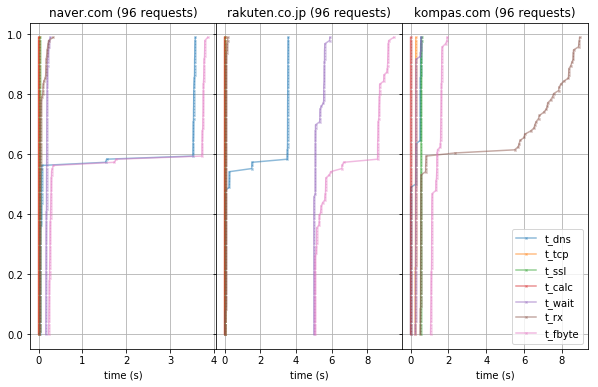

In [84]:
f, axarr = subplots(1,3, sharey=True, figsize=(10,6))
i = 0
for rank in [51, 116, 232]:
    df_observe = df_pass[ df_pass['rank']==rank ]
    for col in t_cols:
        xd, yd = getCDF(df_observe[col])
        axarr[i].plot(xd, yd, label=col, marker='x', alpha=.5, markersize=2)
    axarr[i].grid(True)
    #
    axarr[i].set_xlabel("time (s)")
    #axarr[i].set_ylabel("CDF of website times (using curl)")
    axarr[i].set_title(rank_to_site[rank]+" ("+str(len(df_observe))+" requests)")
    i+=1

axarr[2].legend(loc='best')
f.subplots_adjust(hspace=0, wspace=0)
f.savefig("results/cdf_time_diff_calculated_3sites")

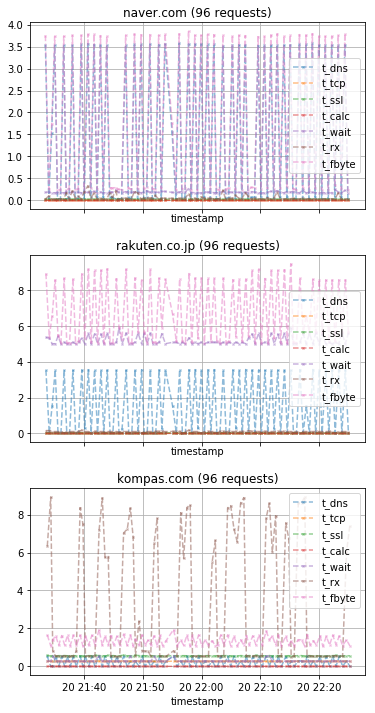

In [87]:
# time vs t_dns for rank 51; t_dns for rank 116; t_rx for 232

f, axarr = subplots(3,1, sharex=True, figsize=(6,12))
i = 0
for rank in [51, 116, 232]:
    df_observe = df_pass[ df_pass['rank']==rank ]
    xd = pd.to_datetime(df_observe.timestamp)

    for col in t_cols:
        yd = df_observe[col]
        axarr[i].plot(xd, yd, label=col, marker='x', alpha=.5, linestyle='--', markersize=2)
    #axarr[i].plot(xd, df_observe['t_fbyte'], label='t_fbyte', marker='o', alpha=.5, linestyle='None', markersize=2)
    
    axarr[i].grid(True)
    axarr[i].set_xlabel("timestamp")
    #axarr[i].set_ylabel("CDF of website times (using curl)")
    axarr[i].legend(loc='best')
    axarr[i].set_title(rank_to_site[rank]+" ("+str(len(df_observe))+" requests)")
    i+=1

f.subplots_adjust(hspace=.25, wspace=0)
f.savefig("results/timeseries_3sites_dns_rx_time")

### stacked plot for avg time calculated

In [132]:
df = df_avg_time[t_cols[:6]].copy()
df['site'] = df.index.map(rank_to_site)

0 len 24


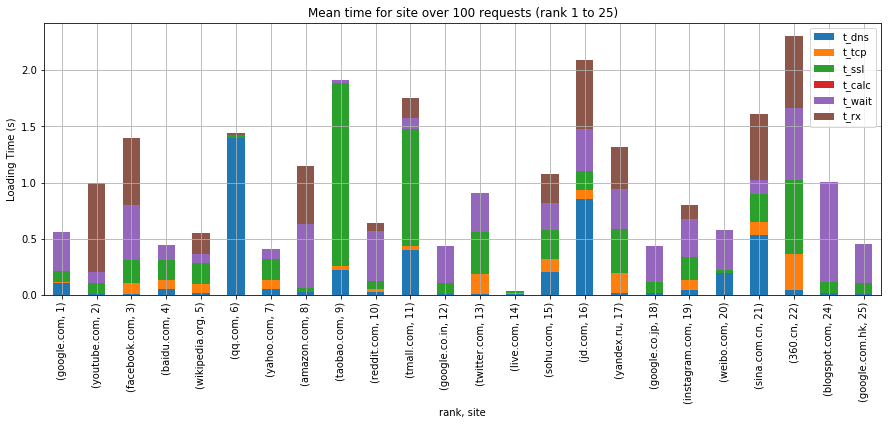

25 len 22


<Figure size 432x288 with 0 Axes>

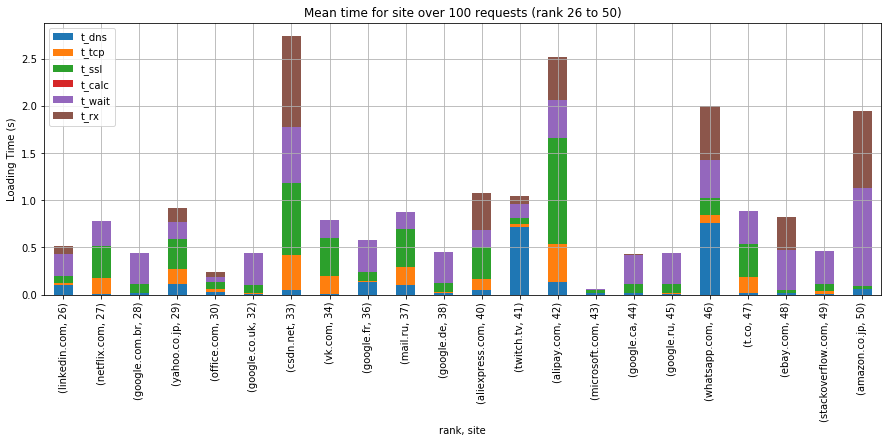

50 len 21


<Figure size 432x288 with 0 Axes>

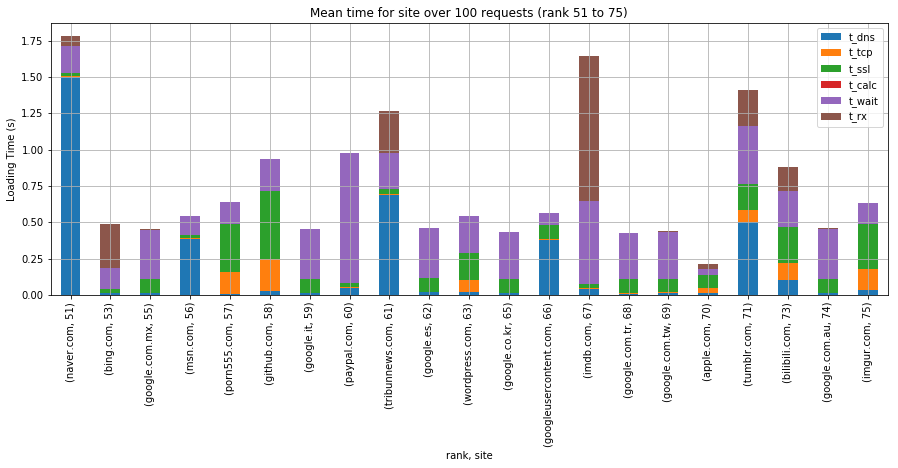

75 len 22


<Figure size 432x288 with 0 Axes>

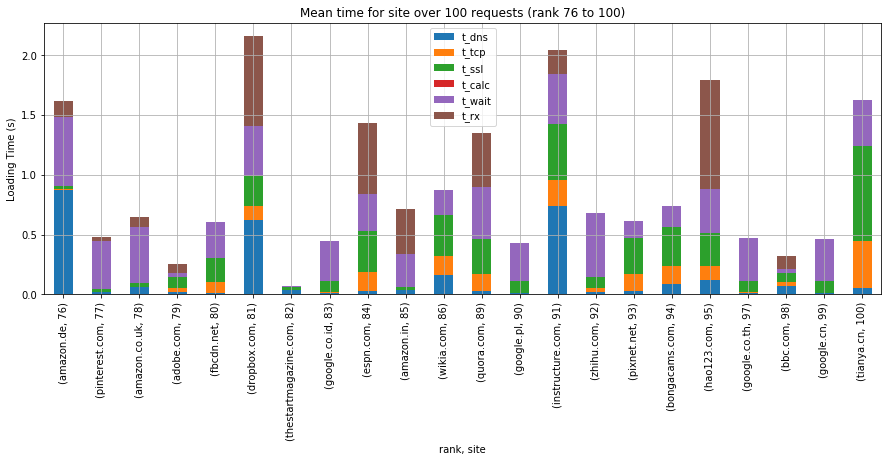

100 len 22


<Figure size 432x288 with 0 Axes>

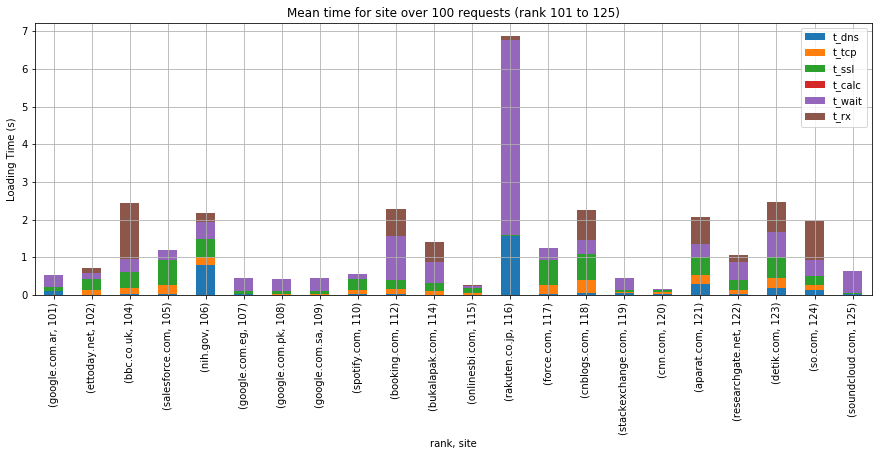

125 len 24


<Figure size 432x288 with 0 Axes>

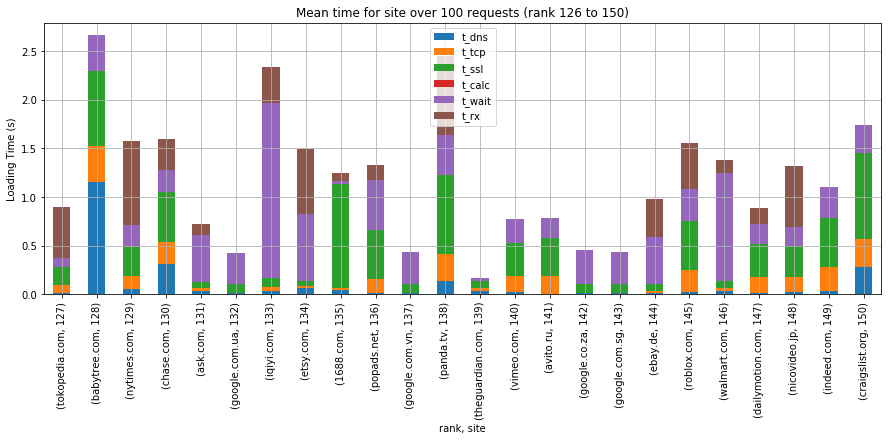

150 len 22


<Figure size 432x288 with 0 Axes>

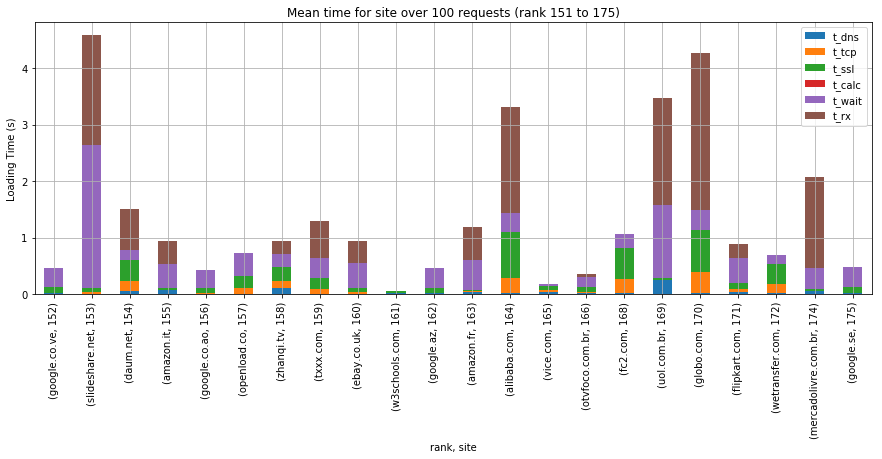

175 len 22


<Figure size 432x288 with 0 Axes>

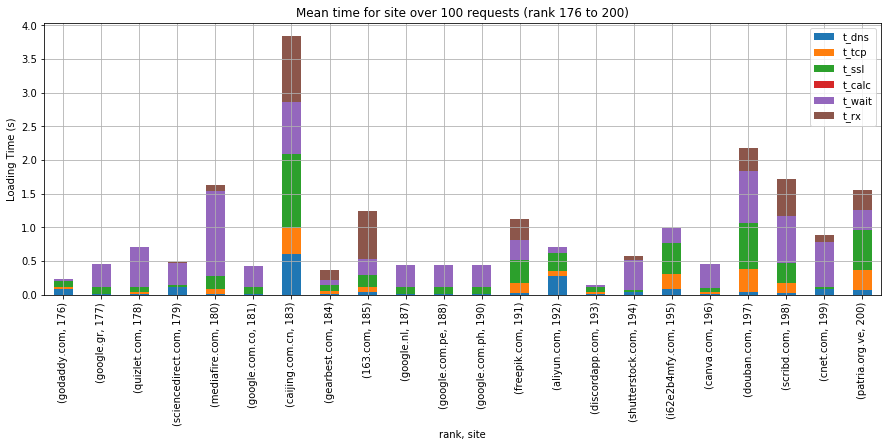

200 len 24


<Figure size 432x288 with 0 Axes>

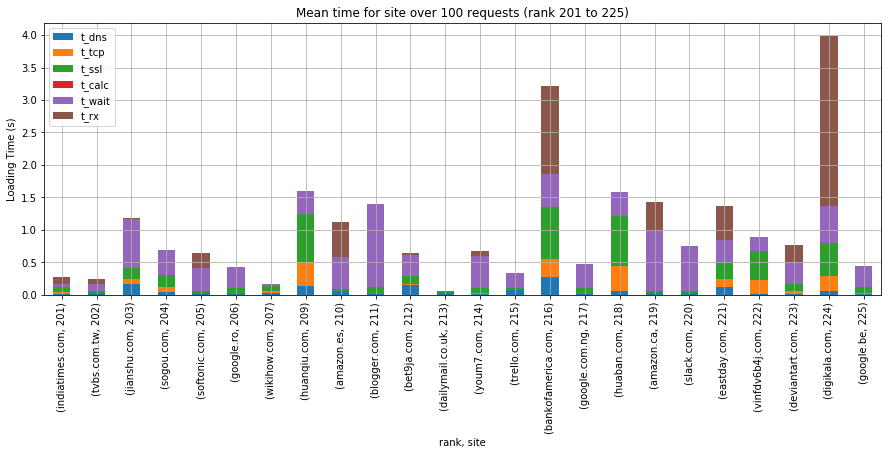

225 len 22


<Figure size 432x288 with 0 Axes>

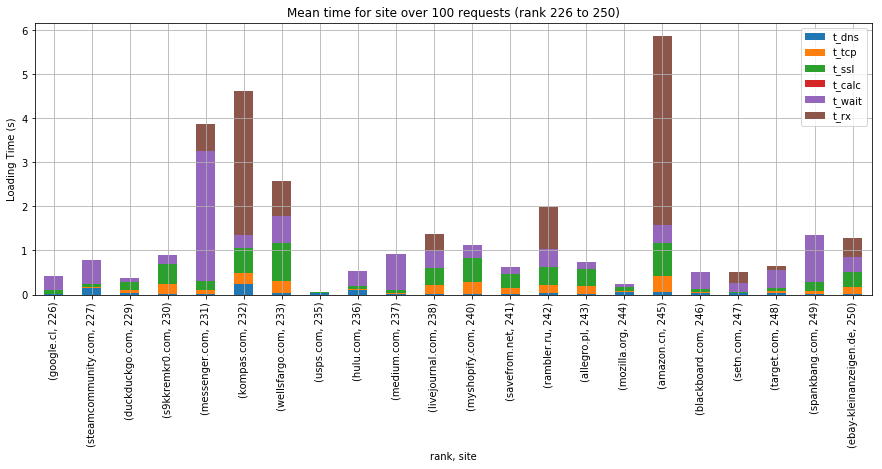

250 len 23


<Figure size 432x288 with 0 Axes>

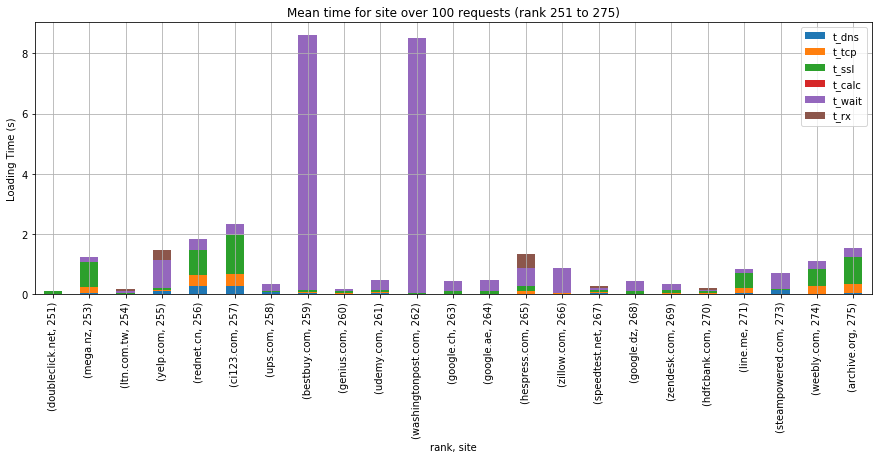

275 len 22


<Figure size 432x288 with 0 Axes>

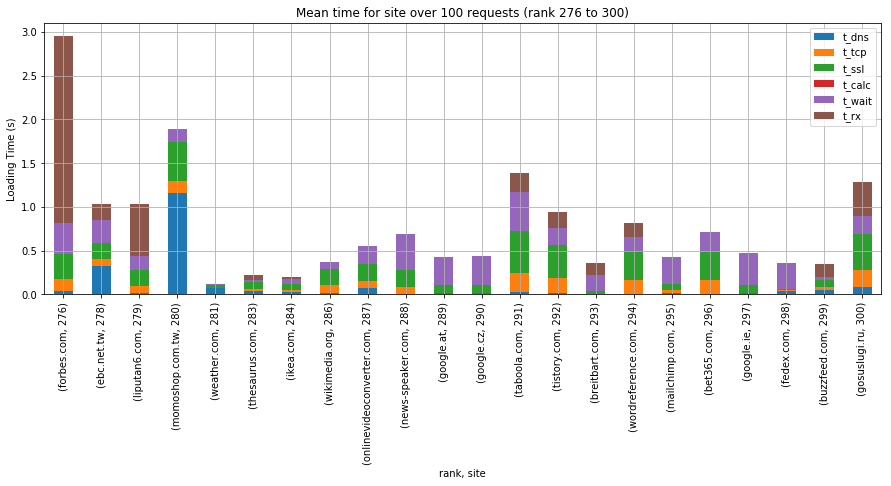

300 len 22


<Figure size 432x288 with 0 Axes>

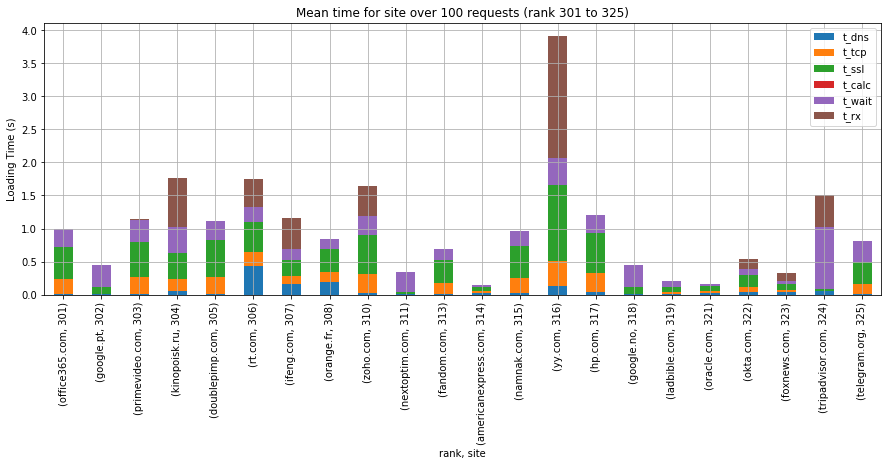

325 len 21


<Figure size 432x288 with 0 Axes>

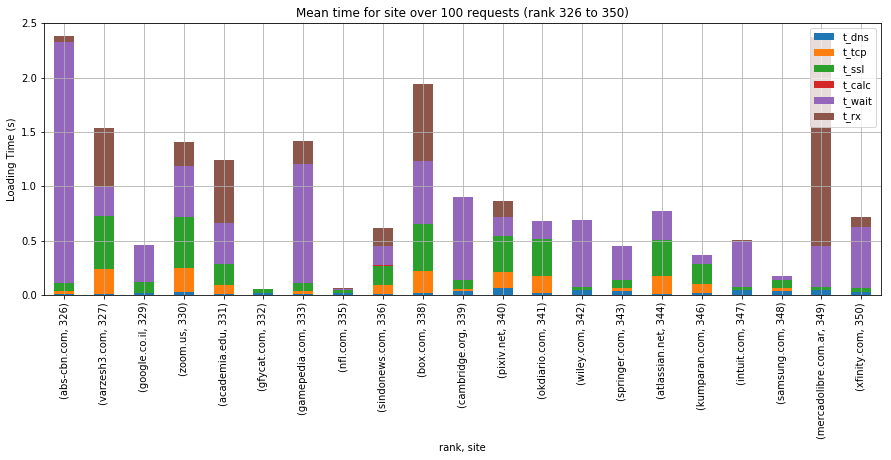

350 len 21


<Figure size 432x288 with 0 Axes>

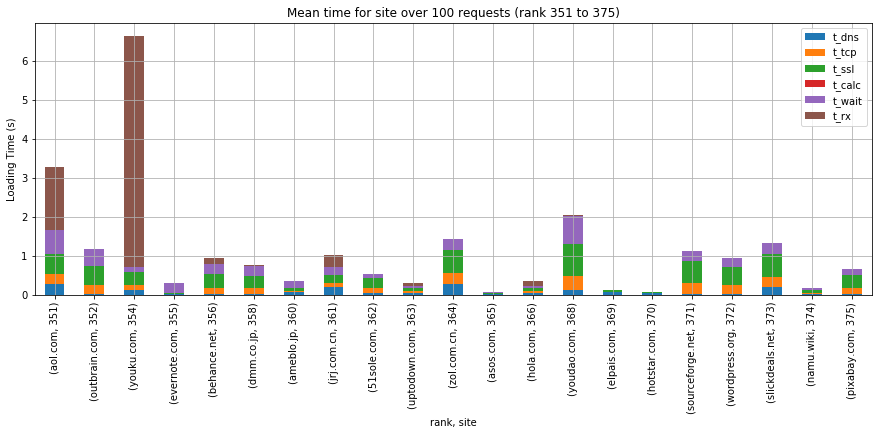

375 len 22


<Figure size 432x288 with 0 Axes>

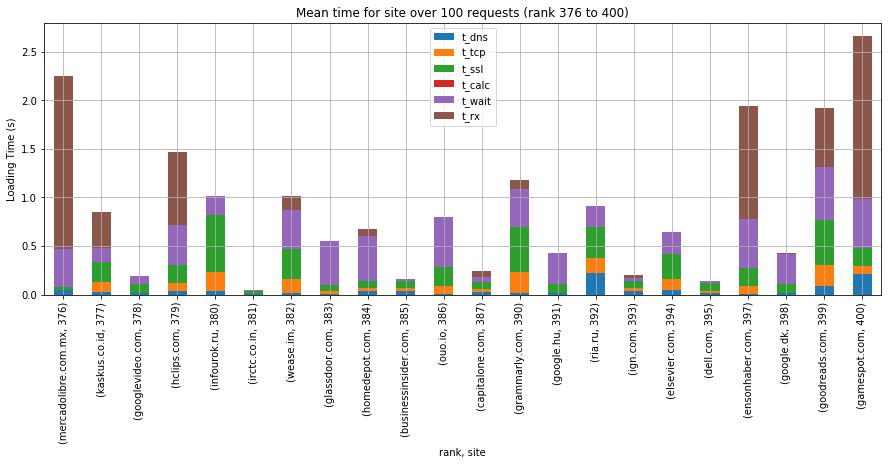

400 len 24


<Figure size 432x288 with 0 Axes>

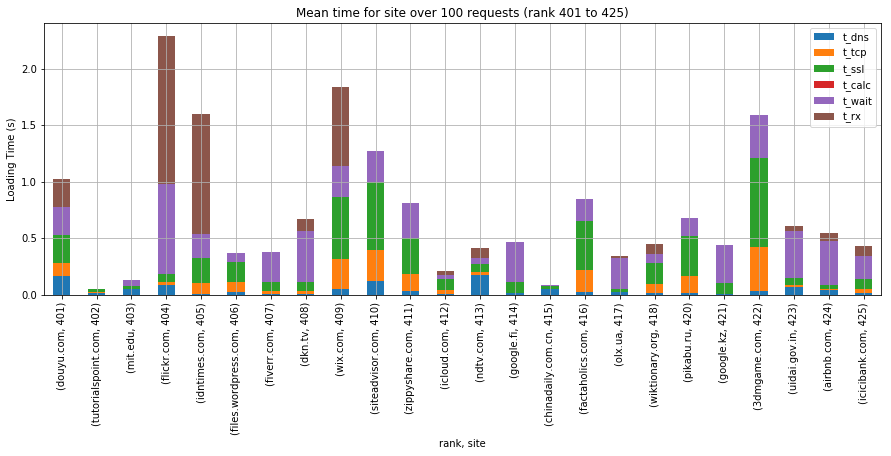

425 len 24


<Figure size 432x288 with 0 Axes>

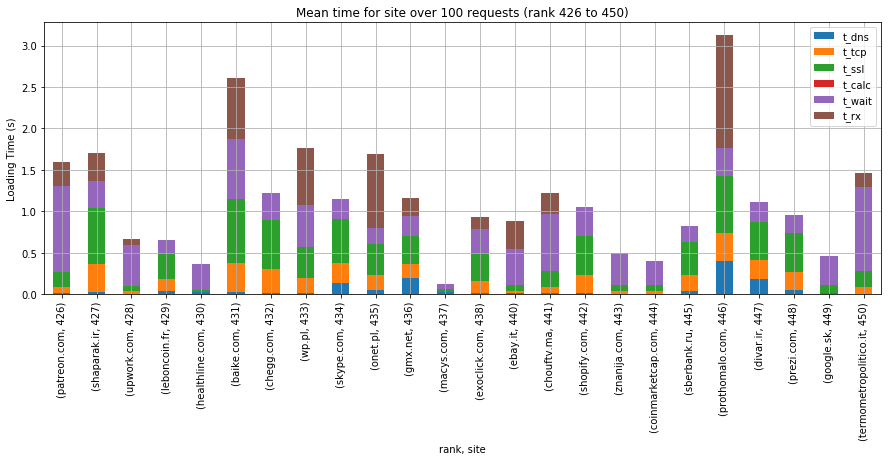

450 len 22


<Figure size 432x288 with 0 Axes>

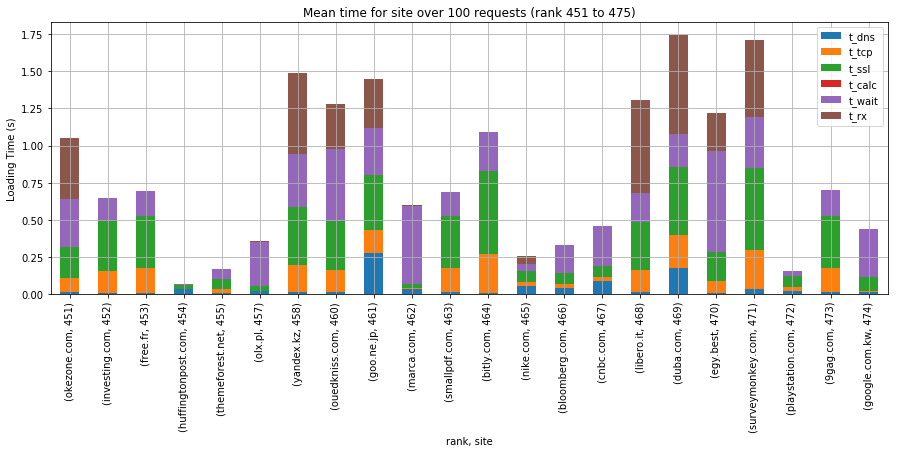

<Figure size 432x288 with 0 Axes>

In [137]:
stp=25
for indx in range(0,len(df),stp):
    df_plot = df.loc[indx+1:indx+stp].reset_index().set_index(["site", "rank"])
    print(indx, "len", len( df_plot ) )
    ax = df_plot.plot.bar(stacked=True,figsize=(15,5))
    ax.set_xlabel("rank, site")
    ax.set_ylabel("Loading Time (s)")
    ax.set_title("Mean time for site over 100 requests (rank %s to %s)" %(indx+1, indx+stp))
    ax.grid(True)
    #ax.set_ylim(0,10)
    plt.show()
    plt.savefig('results/stacked_calc_times_per_site_[%s,%s]'%(indx+1, indx+stp))

In [138]:
#df.plot.bar(stacked=True,figsize=(50,10))

In [139]:
#rank=1
#df_observe = df_pass[ df_pass['rank']==rank ][['timestamp','t_dns', 't_tcp', 't_ssl', 't_wait', 't_rx']].set_index('timestamp')
#df = df_observe
#df.index = pd.to_datetime(df.index)
#df = df.stack().reset_index()
#df.columns = ['timestamp', 'time_diff', 'value']
#df.set_index('time_diff',append=True)['value'].unstack().plot.bar(stacked=True,figsize=(10,8))
#df.set_index('TYPE',append=True)['VOL'].unstack().plot.bar(stacked=True,figsize=(10,8))

# now add ASN and CDN info

In [140]:
#df_avg_time['site']=df_avg_time.index.map(rank_to_site)

result = df_avg_time.merge(df_asn_cdn, left_index=True, on='rank', how='left')

In [383]:
def group_cdn_names(cdn):
    if pd.isnull(cdn):
        return cdn
    elif cdn==False:
        return "No CDN"
    elif cdn in ['Amazon Technologies Inc.', 'Amazon AWS', 'Amazon.com, Inc.', ]:
        return "Amazon AWS"
    elif cdn.lower() != cdn:    # major cdn name not domain
        return cdn
    elif cdn.lower() == cdn and 'cdn' in cdn:
        return "CDN domain"
    elif cdn.lower() == cdn:
        return "Unknown"
    else:
        return "No CDN"
    
def group_cdn_names_wider(cdn):
    if pd.isnull(cdn):
        return cdn
    elif cdn==False:
        return "No CDN"
    elif cdn in ['Amazon Technologies Inc.', 'Amazon AWS', 'Amazon.com, Inc.', 'Amazon Cloudfront']:
        return "Amazon"
    elif cdn in ['Taobao', 'Alibaba']:
        return "Alibaba"
    elif cdn in ['Microsoft', 'Akamai']:
        return 'Akamai'
    elif cdn in ['Google', 'Cloudflare', 'Fastly', 'Akamai']:
        return cdn
    elif cdn.lower() != cdn:    # major cdn name not domain
        return "Other CDNs"
    elif cdn.lower() == cdn and 'cdn' in cdn:
        return "CDN domain"
    elif cdn.lower() == cdn:
        return "Unknown"
    else:
        return "No CDN"

In [384]:
result['cdn_group'] = result['cdn'].apply(group_cdn_names)
result['cdn_group_wide'] = result['cdn'].apply(group_cdn_names_wider)

In [385]:
result.head()

,rank,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,...,t_rx,t_fbyte,site,IP,ASN,cdn_parsed,cdn_whois,cdn,cdn_group,cdn_group_wide
0,1,0,0.109924,0.113395,0.208808,0.208906,0.557897,0.558349,0.109924,0.003471,...,0.000452,0.557897,google.com,172.217.160.238,15169,Google,Google,Google,Google,Google
1,2,0,0.006364,0.009554,0.104926,0.105030,0.207875,0.995865,0.006364,0.003190,...,0.787990,0.207875,youtube.com,172.217.31.14,15169,Google,Google,Google,Google,Google
2,3,0,0.010999,0.103928,0.308093,0.308185,0.803609,1.393983,0.010999,0.092928,...,0.590374,0.803609,facebook.com,157.240.25.35,32934,Facebook,Facebook,Facebook,Facebook,Other CDNs
3,4,0,0.050045,0.132224,0.314754,0.314789,0.444424,0.444517,0.050045,0.082179,...,0.000093,0.444424,baidu.com,123.125.115.110,4808,False,False,False,No CDN,No CDN
4,5,0,0.016001,0.099781,0.282663,0.282779,0.366894,0.555198,0.016001,0.083780,...,0.188304,0.366894,wikipedia.org,103.102.166.224,14907,False,False,False,No CDN,No CDN


# Time performance per CDN 
- 2 websites did not have CDN since they were blocked when trying to find IP: googleusercontent.com (rank 66), wixsite.com (rank 485)
- Of 449 remaining sites, 125 were detected not using CDNs. Google, Amazon AWS, Amazon Cloudfront, Cloudflare, Akamai, Fastly, and Alibaba catered a majority of 222 sites. Other majority well known CDNs accounted for 42 sites with some serving just one of Alexa top 500.
- 36 sites were hosting static content on a domain with "cdn" in its name (assumed CDN based on domain name), marked as "CDN domain". While 24 sites hosted most content on a domain that did not match the website or contain the letters "cdn", hence marked as "Unknown".
- 

In [386]:
print(t_cols)
print(time_cols)

['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx', 't_fbyte']
['time_redirect', 'time_namelookup', 'time_connect', 'time_appconnect', 'time_pretransfer', 'time_starttransfer', 'time_total']


In [387]:
gp = result.groupby('cdn_group')
cdn_group_cnt = gp['rank'].count().sort_values(ascending=False)
print(cdn_group_cnt)

cdn_group
No CDN                    125
Google                     69
Amazon AWS                 46
Cloudflare                 38
CDN domain                 36
Akamai                     29
Fastly                     28
Unknown                    24
Alibaba                     8
Yahoo                       5
Amazon CloudFront           4
OVH                         4
Microsoft                   4
Facebook                    4
Twitter                     2
SoftLayer                   2
ChinaNetCenter              2
LinkedIn CDN                2
Incapsula                   2
Comcast                     1
Edgecast                    1
jsDelivr                    1
HiNet                       1
Hola                        1
Instart Logic               1
Level 3                     1
Open-Connect (Netflix)      1
Orange                      1
Reflected Networks          1
Sohu                        1
StackPath                   1
Taobao                      1
WordPress                   1


In [388]:
major_cdn_names =  ["Google", "Amazon AWS", "Amazon CloudFront","Cloudflare", "Akamai", "Fastly", "Alibaba"]
major_cdn = gp['rank'].count().loc[major_cdn_names]

print( major_cdn )
print( sum( major_cdn ) )
print( cdn_group_cnt.loc[['Unknown', 'No CDN', "CDN domain"]] )
print( sum(cdn_group_cnt) - sum( major_cdn ) - sum(cdn_group_cnt.loc[['Unknown', 'No CDN', "CDN domain"]]) )

cdn_group
Google               69
Amazon AWS           46
Amazon CloudFront     4
Cloudflare           38
Akamai               29
Fastly               28
Alibaba               8
Name: rank, dtype: int64
222
cdn_group
Unknown        24
No CDN        125
CDN domain     36
Name: rank, dtype: int64
42


# Average performance across websites for major CDN groups

In [389]:
df = gp[t_cols].mean()
df['count'] = gp['site'].count()

df_cdn_perf = df[ ~df.index.isin(['Unknown', 'No CDN', "CDN domain"]) ].sort_values(['count'], ascending=False).reset_index().set_index(['cdn_group', 'count'])


In [390]:
df_cdn_perf.head()

,,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
cdn_group,count,,,,,,,
Google,69,0.017591,0.005252,0.093845,0.000098,0.335208,0.018473,0.451995
Amazon AWS,46,0.086183,0.081478,0.184763,0.000077,0.381723,0.393238,0.734224
Cloudflare,38,0.009930,0.055016,0.133035,0.000108,0.489357,0.129843,0.687446
Akamai,29,0.112168,0.045407,0.123973,0.000075,0.723083,0.039195,1.004706
Fastly,28,0.064274,0.076305,0.171126,0.000092,0.263554,0.247889,0.575352


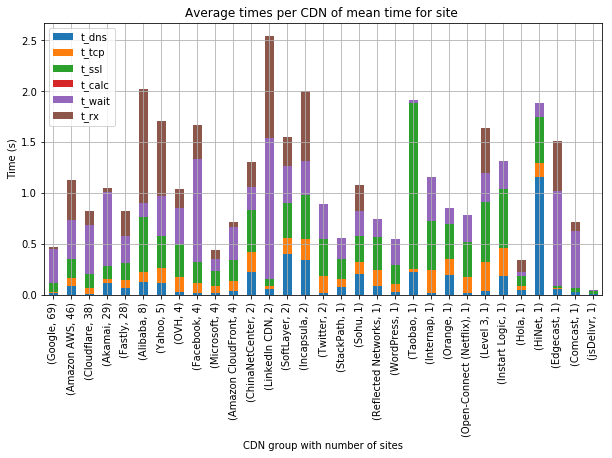

In [391]:
ax = df_cdn_perf[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("CDN group with number of sites")
ax.set_ylabel("Time (s)")
ax.set_title("Average times per CDN of mean time for site ")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_cdn')

In [392]:
result [ result['cdn_group']=='Amazon AWS' ]

,rank,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,...,t_rx,t_fbyte,site,IP,ASN,cdn_parsed,cdn_whois,cdn,cdn_group,cdn_group_wide
7,8,0,0.026609,0.029951,0.058205,0.058297,0.628283,1.150735,0.026609,0.003342,...,0.522453,0.628283,amazon.com,176.32.98.166,16509,Amazon AWS,False,Amazon AWS,Amazon AWS,Amazon
49,50,0,0.054098,0.057464,0.085901,0.085993,1.131735,1.942723,0.054098,0.003366,...,0.810988,1.131735,amazon.co.jp,52.119.164.121,16509,Amazon AWS,Amazon Technologies Inc.,Amazon AWS,Amazon AWS,Amazon
66,67,0,0.042250,0.045886,0.076262,0.076294,0.647441,1.644116,0.042250,0.003636,...,0.996675,0.647441,imdb.com,52.94.225.248,16509,Amazon AWS,Amazon Technologies Inc.,Amazon AWS,Amazon AWS,Amazon
75,76,0,0.874077,0.877760,0.907019,0.907117,1.479694,1.614556,0.874077,0.003682,...,0.134862,1.479694,amazon.de,52.95.120.34,16509,Amazon AWS,False,Amazon AWS,Amazon AWS,Amazon
77,78,0,0.060794,0.064202,0.092571,0.092659,0.559548,0.650350,0.060794,0.003408,...,0.090803,0.559548,amazon.co.uk,54.239.33.58,16509,Amazon AWS,Amazon Technologies Inc.,Amazon AWS,Amazon AWS,Amazon
83,84,0,0.029139,0.190083,0.531749,0.531849,0.841987,1.433082,0.029139,0.160944,...,0.591094,0.841987,espn.com,54.76.191.85,16509,espncdn.com,Amazon Technologies Inc.,Amazon Technologies Inc.,Amazon AWS,Amazon
84,85,0,0.034353,0.037411,0.063824,0.063916,0.335265,0.714143,0.034353,0.003058,...,0.378878,0.335265,amazon.in,52.95.120.67,16509,Amazon AWS,Amazon Technologies Inc.,Amazon AWS,Amazon AWS,Amazon
88,89,0,0.029403,0.168767,0.461991,0.462091,0.894404,1.351686,0.029403,0.139364,...,0.457283,0.894404,quora.com,54.165.72.127,14618,quoracdn.net,Amazon Technologies Inc.,Amazon Technologies Inc.,Amazon AWS,Amazon
90,91,0,0.739608,0.958722,1.422077,1.422114,1.841268,2.038914,0.739608,0.219113,...,0.197647,1.841268,instructure.com,54.165.95.219,14618,False,Amazon Technologies Inc.,Amazon Technologies Inc.,Amazon AWS,Amazon
105,106,0,0.792603,1.017692,1.487568,1.487604,1.940052,2.165884,0.792603,0.225090,...,0.225832,1.940052,nih.gov,54.235.145.223,14618,False,"Amazon.com, Inc.","Amazon.com, Inc.",Amazon AWS,Amazon


## CDN vs NO CDN

- Google CDN average total time per requests in about 0.4s. Majority delay is wait time (since most responses were redirects, not much data download and low receive time). t_wait - t_tcp can give us an estimate of the server wait. Google CDN has a very large server wait time, in comparison name resolution, tcp handshake, ssl negotiation, and reception time is lesser than server wait time.
    - Non google.* domains: blogger.com and blogspot.com have higher wait times and end up redirecting, while youtube.com has a high receive time possibly due to larger download size.
    - google.* domains have the same behavior (overall 1/3rd returned 200 OK while the rest redirected). Even with much smaller size, the redirected page (response code 302) took an extra 0.3s in wait time compared to the status 200 OK page.
- 46 sites on Amazon AWS have similar performance to 4 sites on Cloudfront, except for higher reception time for sites on AWS. Average total waiting time is 1.127s
    - 10 amazon.* domains with similar performance - either 200 OK page with a 1.5s reception time (2.7s total time), or a 503 server unavailable with 0.7s total time. All on ASN16509 (except amazon.cn)
    - 36 distributed across 2 ASNs with no pattern. Average total_time about 1s. AS14618 and ASN16509.
    - 4 sites on Cloudfront also no particular pattern (07s total time average). Above 2 ASNs, confirming that some websites on Amazon AWS might be using Cloudfront as their CDN.
    - trello.com is on AS16625 (Akamai) but seems to be using majority amazon services on its web page, detecting CDN as Cloudfront even though its on Akamai. It would be best for it to move to Cloudfront if a majority of the resources are loaded from there.
- 29 sites on Akamai, and 4 on Microsoft, have a large server waiting time across sites. Avg total time is .97s, avg waiting time is  0.64s.
    - 2 websites, washingtonpost.com and bestbuy.com, are responsible for increasing the average wait time (each more than 8s). While bestbuy at least returned a 200 OK response, washingtonpost only redirected us yet the wait time was the majority of the total time. This is either done intentionally against web scraping scripts, or is possibly a mistake.
    - 3 sites, liputan6.com, naver.com, and asos.com were using Akamai resources for most static objects on their page. Their ASNs do not belong to Akamai but we've considered them as using Akamai due to the external urls to hosted objects in their home pages. 
    - 3 websites, microsoft.com, msn.com, and skype.com are using Microsoft as their CDN which is part of Akamai for Microsoft services (including office.com, office365.com, bing.com, and live.com). Individually, microsoft websites perform much better than their Akamai counterpart. Avg total time for Microsoft is 0.26s (0.56s for live.com on a different ASN). Akamai had a more inconsistent performance with an avg 0.92s total time.
    - ASN16625 has an overall inconsistent performance (especially due to bestbuy.com). Without bestbuy.com, the avg total time is only .33s with wait time .16s.
- 9 sites use Alibaba. Comparison shows that Alibaba CDN (including Taobao sites) have the worst performance across CDNs, especially during SSL negotiation and data received. Average total waiting time is 2s. SSL negotiation time is 0.6s and receive time is almost 1s.
    - Detailed analysis shows 2 ASNs catering to these 8 sites: 45102 (Alibaba) and 37963 (Taobao), both owned by Alibaba CDN.
    - 3 of 5 sites on AS37963 have an average t_ssl (mean t_ssl for site across 100 requests) over 1s.
    - 2 of 4 sites on AS45102 had a very high t_rx (alibaba.com: 1.88s, youku.com: 5.9s). This may be because the size of data downloaded by youku.com on request an order of magnitude higher than the overall average (~1MB).
- 28 sites use Fastly. The average total time is .82s with receive time + wait time accounting for .24s and .26s respectively. All sites were on AS54113
    - rank 10 site reddit.com uses fastly, but most requests to reddit were blocked by the server. Only 5 requests got a 200 OK response. For other sites, either they consistently redirected or consistently gave 200 OK. Server wait time was almost 1.1s regardless of status code.
    - bbc.co.uk, nytimes.com, forbes.com, etsy.com, scribd.com all had relatively high receive time, possibly as they were loading a larger homepage than others.
    - Overall sites returning 200 status OK had a higher ssl, receive and wait time, while redirecting sites had high ssl negotiation

In [393]:
gp2 = result.groupby('cdn_group_wide')
cdn_group_cnt = gp2['rank'].count().sort_values(ascending=False)

In [394]:
cdn_group_cnt

cdn_group_wide
No CDN        125
Google         69
Amazon         46
Other CDNs     41
Cloudflare     38
CDN domain     36
Akamai         33
Fastly         28
Unknown        24
Alibaba         9
Name: rank, dtype: int64

In [395]:
df2 = gp2[t_cols + ['time_total']].mean()
df2['count'] = gp2['site'].count()
df2['sort_by'] = [4,4,4,2,4,4,4,0,3,1]
df_cdn_perf2 = df2.sort_values(['sort_by','count'], ascending=False).reset_index().set_index(['cdn_group_wide', 'count'])



In [401]:
df_cdn_perf2

,,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,sort_by
cdn_group_wide,count,,,,,,,,,
Google,69,0.017591,0.005252,0.093845,0.000098,0.335208,0.018473,0.451995,0.470468,4
Amazon,46,0.086183,0.081478,0.184763,0.000077,0.381723,0.393238,0.734224,1.127462,4
Cloudflare,38,0.009930,0.055016,0.133035,0.000108,0.489357,0.129843,0.687446,0.817289,4
Akamai,33,0.100544,0.047839,0.127119,0.000076,0.649934,0.045246,0.925510,0.970756,4
Fastly,28,0.064274,0.076305,0.171126,0.000092,0.263554,0.247889,0.575352,0.823241,4
Alibaba,9,0.132332,0.097010,0.660236,0.000093,0.121485,0.998126,1.011155,2.009281,4
Other CDNs,41,0.122349,0.130701,0.286287,0.000079,0.438320,0.290617,0.977735,1.268352,3
CDN domain,36,0.097732,0.153082,0.352203,0.000072,0.282013,0.284190,0.885101,1.169292,2
Unknown,24,0.079199,0.196765,0.452525,0.000075,0.320600,0.551725,1.049164,1.600889,1


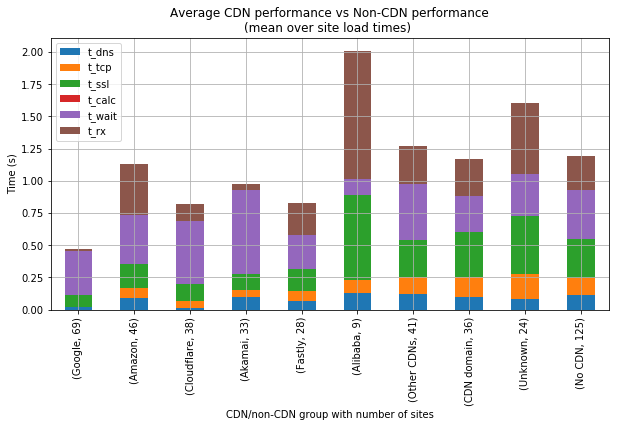

In [402]:
ax = df_cdn_perf2[t_cols[:6]].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("CDN/non-CDN group with number of sites")
ax.set_ylabel("Time (s)")
ax.set_title("Average CDN performance vs Non-CDN performance\n(mean over site load times) ")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_cdn_vs_noncdn')

In [403]:
def stack_bar_time_plot(df):
    ax = df[t_cols[:6]].plot.bar(stacked=True,figsize=(10,5))
    ax.set_ylabel("Time (s)")
    ax.grid(True)
    return ax

## Individual group analysis

#### Google

In [404]:
site_cdn_ranks = [r for r,s in rank_to_site.items() if 'google.' in s]
print(site_cdn_ranks)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean()
df

[1, 12, 18, 25, 28, 32, 36, 38, 44, 45, 55, 59, 62, 65, 68, 69, 74, 83, 90, 97, 99, 101, 107, 108, 109, 132, 137, 142, 143, 152, 156, 162, 175, 177, 181, 187, 188, 190, 206, 217, 225, 226, 263, 264, 268, 289, 290, 297, 302, 318, 329, 391, 398, 414, 421, 449, 474]


,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
response_code,,,,,,,,,
200,0.023962,0.003097,0.095911,0.000098,0.119084,0.001555,0.242152,0.243707,14930.730167
302,0.015131,0.003146,0.095404,0.000098,0.448986,0.000085,0.562765,0.562850,327.804513


[2, 24, 110, 205, 211, 251, 293, 311, 355, 378, 384, 488]


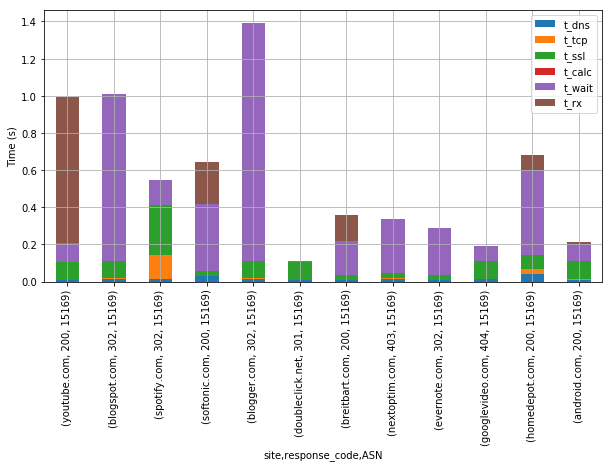

In [405]:
site_cdn_ranks2 = list( result[result['cdn_group_wide']=='Google']['rank'] )
site_cdn_ranks3 = [x for x in site_cdn_ranks2 if x not in site_cdn_ranks]
print(site_cdn_ranks3)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks3) ].groupby(['rank','response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_asn_cdn, on='rank')
#df

ax = stack_bar_time_plot(df.set_index(['site', 'response_code','ASN']))
plt.savefig("results/stacked_calc_times_per_site_nongoogle")

#### Amazon


In [458]:
site_cdn_ranks = [r for r,s in rank_to_site.items() if 'amazon.' in s]
print(site_cdn_ranks)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['response_code'])
df = gp_check[t_cols + ['time_total', 'size_download']].mean()
df

[8, 50, 76, 78, 85, 155, 163, 210, 219, 245]


,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
response_code,,,,,,,,,
200,0.077595,0.064855,0.151913,0.000083,0.663519,1.515899,0.957964,2.473863,183466.665385
503,0.190517,0.009939,0.041107,0.000092,0.464645,0.000099,0.706302,0.706401,4003.029545


In [459]:
#df_asn_cdn[ df_asn_cdn['rank'].isin(site_cdn_ranks3) ]

[67, 84, 89, 91, 106, 125, 165, 168, 172, 174, 179, 202, 220, 223, 247, 266, 291, 299, 303, 322, 332, 349, 370, 376, 390, 393, 399, 417, 424, 432, 442, 448, 457, 463, 481, 497]


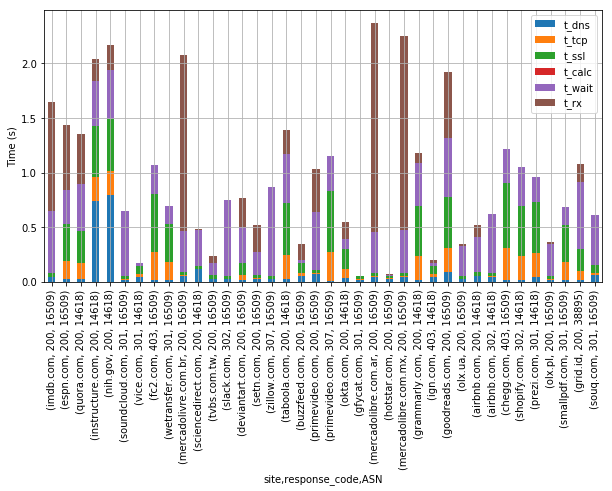

In [460]:
site_cdn_ranks2 = list( result[result['cdn_group_wide']=='Amazon']['rank'] )
site_cdn_ranks3 = [x for x in site_cdn_ranks2 if x not in site_cdn_ranks]
print(site_cdn_ranks3)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks3) ].groupby(['rank','response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_asn_cdn, on='rank')
#df

ax = stack_bar_time_plot(df.set_index(['site', 'response_code', 'ASN']))
plt.savefig("results/stacked_calc_times_per_site_nonamazon")

In [409]:
site_cdn_ranks = result[ result['cdn_group']=='Amazon CloudFront' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
gp_check['timestamp'].count()
#gp_check[t_cols + ['size_download']].mean().reset_index().merge(df_asn_cdn, on='rank')

rank  response_code
215   301              96
330   200              95
344   404              95
430   200              95
Name: timestamp, dtype: int64

#### Akamai

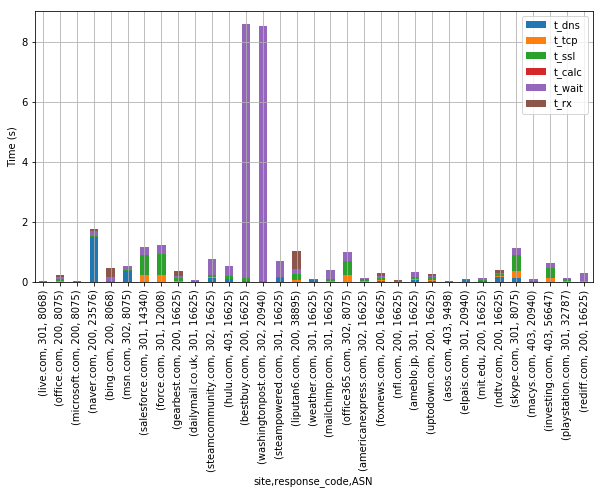

In [455]:
site_cdn_ranks = result[ result['cdn_group_wide']=='Akamai' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_asn_cdn, on='rank')

ax = stack_bar_time_plot(df.set_index(['site', 'response_code', 'ASN']))
plt.savefig("results/stacked_calc_times_per_site_akamai")

In [454]:
site_cdn_ranks = result[ result['cdn_group_wide']=='Akamai' ]['rank']
gp_check = df_pass[ (df_pass['rank'].isin(site_cdn_ranks)) & (df_pass['rank']!=259) ].merge(df_asn_cdn[['ASN','rank']], on='rank').groupby(['ASN'])
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index()
df

,ASN,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
0,8068,0.012202,0.002615,0.021174,0.000088,0.075699,0.150627,0.111778,0.262405,5.793313e+04
1,8075,0.116425,0.100852,0.225954,0.000080,0.143566,0.011129,0.586875,0.598005,1.774072e+04
2,9498,0.013755,0.002871,0.024545,0.000094,0.019456,0.000080,0.060721,0.060801,2.620000e+02
3,12008,0.012255,0.243282,0.678671,0.000038,0.312284,0.000011,1.246531,1.246543,0.000000e+00
4,14340,0.016254,0.242549,0.664242,0.000037,0.262158,0.000010,1.185239,1.185249,0.000000e+00
5,16625,0.065235,0.018804,0.057906,0.000068,0.163665,0.032051,0.305677,0.337728,8.740216e+04
6,20940,0.042173,0.002840,0.029569,0.000094,2.184070,0.000060,2.258746,2.258806,1.732353e+02
7,23576,1.500233,0.002963,0.025472,0.000099,0.187175,0.065178,1.715942,1.781120,1.748088e+05
8,32787,0.022765,0.026478,0.073273,0.000106,0.032106,0.000011,0.154728,0.154739,0.000000e+00
9,38895,0.014098,0.082115,0.183100,0.000100,0.162658,0.589599,0.442070,1.031669,1.045178e+06


In [428]:
d = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].merge(df_asn_cdn[['ASN','rank']], on='rank')
d[ d['ASN'].isin([16625]) ].mean()

response_code           258.116434
size_request             78.721224
size_upload               0.000000
size_download         83655.875582
size_header             390.322688
time_redirect             0.000000
time_namelookup           0.063612
time_connect              0.082763
time_appconnect           0.141628
time_pretransfer          0.141698
time_starttransfer        0.691870
time_total                0.722460
rank                    310.487026
t_dns                     0.063612
t_tcp                     0.019151
t_ssl                     0.058865
ssl_flag                  1.000000
t_calc                    0.000070
t_wait                    0.550172
t_fbyte                   0.691870
t_rx                      0.030590
fail                      0.000000
ASN                   16625.000000
dtype: float64

#### Alibaba/Taobao

In [449]:
site_cdn_ranks = result[ result['cdn_group_wide']=='Alibaba' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
gp_check['timestamp'].count()

rank  response_code
9     302              92
11    200              96
40    200              96
127   200              96
135   200              95
164   200              96
192   302              96
354   200              95
362   404              95
Name: timestamp, dtype: int64

In [452]:
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_asn_cdn, on='rank')
df

,rank,response_code,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download,site,IP,ASN,cdn_parsed,cdn_whois,cdn
0,9,302,0.226125,0.027564,1.634377,0.000035,0.027441,0.000078,1.915543,1.915620,258.000000,taobao.com,140.205.94.189,37963,Taobao,Taobao,Taobao
1,11,200,0.403465,0.027723,1.046180,0.000100,0.098006,0.176988,1.575475,1.752463,227991.114583,tmall.com,140.205.130.99,37963,Alibaba,Taobao,Alibaba
2,40,200,0.052061,0.118037,0.338859,0.000102,0.172320,0.395000,0.681379,1.076379,37401.052083,aliexpress.com,198.11.132.250,45102,Alibaba,Alibaba,Alibaba
3,127,200,0.013479,0.082343,0.187081,0.000106,0.089074,0.521814,0.372082,0.893896,116462.156250,tokopedia.com,47.74.244.18,45102,ecs7.tokopedia.net,Alibaba,Alibaba
4,135,200,0.039820,0.027511,1.069523,0.000109,0.029259,0.084358,1.166222,1.250579,93881.000000,1688.com,140.205.174.2,37963,Alibaba,Taobao,Alibaba
5,164,200,0.017841,0.262486,0.812662,0.000102,0.332617,1.886106,1.425709,3.311815,99769.520833,alibaba.com,198.11.132.23,45102,Alibaba,Alibaba,Alibaba
6,192,302,0.276168,0.081533,0.265356,0.000102,0.085232,0.000089,0.708391,0.708479,31.000000,aliyun.com,140.205.172.21,37963,Alibaba,Taobao,Alibaba
7,354,200,0.116848,0.128758,0.332961,0.000137,0.139284,5.918629,0.717989,6.636618,967852.221053,youku.com,106.11.186.25,37963,Alibaba,Taobao,Alibaba
8,362,404,0.045178,0.117138,0.255125,0.000043,0.120128,0.000070,0.537611,0.537681,315.000000,51sole.com,47.90.2.56,45102,False,Alibaba,Alibaba


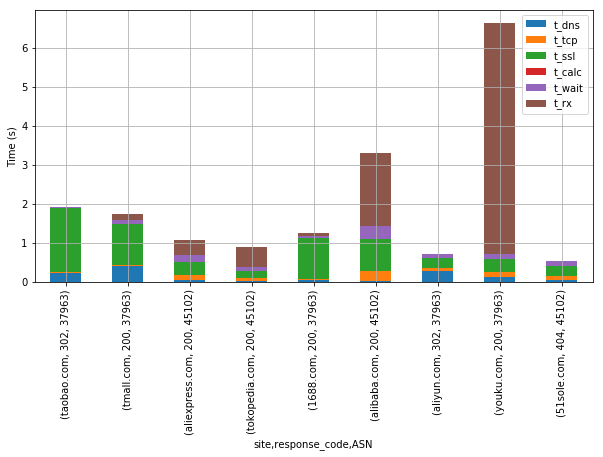

In [413]:
ax = stack_bar_time_plot(df.set_index(['site', 'response_code', 'ASN']))
plt.savefig("results/stacked_calc_times_per_site_alibaba")

#### Fastly

In [437]:
site_cdn_ranks = result[ result['cdn_group_wide']=='Fastly' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
#gp_check['timestamp'].count()

In [442]:
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_asn_cdn, on='rank')
#df

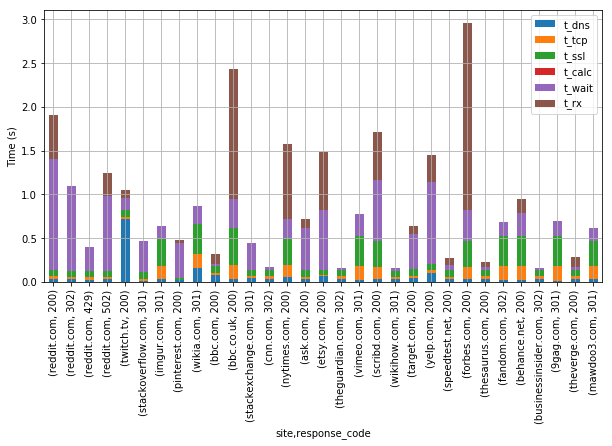

In [445]:
ax = stack_bar_time_plot(df.set_index(['site', 'response_code']))
plt.savefig("results/stacked_calc_times_per_site_fastly")

In [448]:
df.groupby('response_code').mean()

,rank,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
response_code,,,,,,,,,,
200,192.750,0.084069,0.063990,0.148795,0.000087,0.396926,0.460858,0.693866,1.154724,238791.953639
301,204.375,0.041735,0.108101,0.232041,0.000097,0.200600,0.000061,0.582573,0.582634,124.875000
302,193.400,0.031263,0.055173,0.125535,0.000103,0.243798,0.000024,0.455872,0.455896,9.400000
429,10.000,0.025863,0.028449,0.071476,0.000099,0.267373,0.000086,0.393259,0.393345,1064.014085
502,10.000,0.028671,0.028129,0.070329,0.000091,0.853360,0.257918,0.980579,1.238497,266414.117647


# ASN multiple for same cdn?

In [468]:
gp3 = result.groupby(['ASN', 'cdn_group_wide'])

In [469]:
cdn_asn_detect = gp3['site'].count().sort_values(ascending=False).reset_index()

In [470]:
# Check if multiple CDNs were detected for the same ASN -> should not happen

gp4 = cdn_asn_detect.groupby('ASN')
df3 = gp4.aggregate(lambda x: list(x)).reset_index().set_index('ASN')
df3['num_cdn']=gp4['site'].count()
df3['num_sites']=gp4['site'].sum()

df3[ df3['num_cdn']>1 ]

,cdn_group_wide,site,num_cdn,num_sites
ASN,,,,
2635,"[Unknown, Other CDNs]","[1, 1]",2,2
4134,"[Unknown, No CDN]","[2, 2]",2,4
4808,"[No CDN, Other CDNs, Unknown, Amazon]","[4, 2, 1, 1]",4,8
9808,"[Other CDNs, No CDN]","[1, 1]",2,2
14618,"[Amazon, Other CDNs]","[12, 2]",2,14
16509,"[Amazon, Other CDNs]","[32, 3]",2,35
16625,"[Akamai, Other CDNs]","[16, 1]",2,17
23724,"[No CDN, Unknown, CDN domain]","[2, 1, 1]",3,4
24940,"[No CDN, CDN domain]","[2, 1]",2,3


In [471]:
asns = df3[ df3['num_cdn']>1 ].index

result[result['ASN'].isin([38895])]

,rank,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,...,t_rx,t_fbyte,site,IP,ASN,cdn_parsed,cdn_whois,cdn,cdn_group,cdn_group_wide
228,229,0,0.025450,0.109091,0.289125,0.289227,0.371612,0.371692,0.025450,0.083641,...,0.000080,0.371612,duckduckgo.com,54.254.135.186,38895,False,False,False,No CDN,No CDN
278,279,0,0.014098,0.096213,0.279313,0.279412,0.442070,1.031669,0.014098,0.082115,...,0.589599,0.442070,liputan6.com,54.169.185.189,38895,Akamai,Amazon Technologies Inc.,Akamai,Akamai,Akamai
330,331,0,0.006640,0.088472,0.280295,0.280333,0.658537,1.238364,0.006640,0.081832,...,0.579827,0.658537,academia.edu,46.137.210.247,38895,a.academia-assets.com,False,a.academia-assets.com,Unknown,Unknown
345,346,0,0.017006,0.099107,0.282744,0.282856,0.365453,0.365550,0.017006,0.082101,...,0.000097,0.365453,kumparan.com,54.169.126.137,38895,Cloudflare,Amazon Technologies Inc.,Cloudflare,Cloudflare,Cloudflare
480,481,0,0.017945,0.100338,0.302425,0.302523,0.910996,1.080540,0.017945,0.082392,...,0.169544,0.910996,grid.id,52.77.65.203,38895,False,Amazon Technologies Inc.,Amazon Technologies Inc.,Amazon AWS,Amazon


In [472]:
result[result['ASN'].isin([37963])]

,rank,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,...,t_rx,t_fbyte,site,IP,ASN,cdn_parsed,cdn_whois,cdn,cdn_group,cdn_group_wide
8,9,0,0.226125,0.253689,1.888066,1.888102,1.915543,1.915620,0.226125,0.027564,...,0.000078,1.915543,taobao.com,140.205.94.189,37963,Taobao,Taobao,Taobao,Taobao,Alibaba
10,11,0,0.403465,0.431188,1.477369,1.477469,1.575475,1.752463,0.403465,0.027723,...,0.176988,1.575475,tmall.com,140.205.130.99,37963,Alibaba,Taobao,Alibaba,Alibaba,Alibaba
32,33,0,0.045427,0.417634,1.181024,1.181133,1.776549,2.744571,0.045427,0.372207,...,0.968022,1.776549,csdn.net,47.95.164.112,37963,csdnimg.cn,False,csdnimg.cn,Unknown,Unknown
41,42,0,0.133390,0.533856,1.656146,1.656180,2.059218,2.522719,0.133390,0.400465,...,0.463501,2.059218,alipay.com,110.75.129.5,37963,False,False,False,No CDN,No CDN
117,118,0,0.049640,0.391884,1.097528,1.097639,1.452106,2.258943,0.049640,0.342245,...,0.806837,1.452106,cnblogs.com,42.121.252.58,37963,False,False,False,No CDN,No CDN
127,128,0,1.156701,1.526313,2.289830,2.289867,2.659168,2.659252,1.156701,0.369613,...,0.000085,2.659168,babytree.com,59.110.149.245,37963,False,False,False,No CDN,No CDN
134,135,0,0.039820,0.067331,1.136854,1.136963,1.166222,1.250579,0.039820,0.027511,...,0.084358,1.166222,1688.com,140.205.174.2,37963,Alibaba,Taobao,Alibaba,Alibaba,Alibaba
137,138,0,0.136395,0.410933,1.226159,1.226270,1.632630,2.450855,0.136395,0.274539,...,0.818225,1.632630,panda.tv,182.92.20.106,37963,cdn.xiongmaoxingyan.com,False,cdn.xiongmaoxingyan.com,CDN domain,CDN domain
157,158,0,0.109457,0.225982,0.480753,0.480790,0.709136,0.944882,0.109457,0.116526,...,0.235746,0.709136,zhanqi.tv,182.92.104.151,37963,False,False,False,No CDN,No CDN
191,192,0,0.276168,0.357700,0.623056,0.623158,0.708391,0.708479,0.276168,0.081533,...,0.000089,0.708391,aliyun.com,140.205.172.21,37963,Alibaba,Taobao,Alibaba,Alibaba,Alibaba


In [473]:
result[result['ASN'].isin([4808])]

,rank,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,...,t_rx,t_fbyte,site,IP,ASN,cdn_parsed,cdn_whois,cdn,cdn_group,cdn_group_wide
3,4,0,0.050045,0.132224,0.314754,0.314789,0.444424,0.444517,0.050045,0.082179,...,0.000093,0.444424,baidu.com,123.125.115.110,4808,False,False,False,No CDN,No CDN
20,21,0,0.530565,0.647009,0.900001,0.900119,1.023202,1.609761,0.530565,0.116444,...,0.586559,1.023202,sina.com.cn,202.108.33.107,4808,False,False,False,No CDN,No CDN
244,245,0,0.050351,0.416995,1.175379,1.175416,1.586256,5.875158,0.050351,0.366644,...,4.288903,1.586256,amazon.cn,54.222.60.218,4808,Amazon AWS,False,Amazon AWS,Amazon AWS,Amazon
306,307,0,0.160122,0.276468,0.530897,0.530936,0.683477,1.165961,0.160122,0.116347,...,0.482484,0.683477,ifeng.com,123.103.122.24,4808,False,ChinaNetCenter,ChinaNetCenter,ChinaNetCenter,Other CDNs
360,361,0,0.199127,0.293442,0.504512,0.504617,0.700022,1.012062,0.199127,0.094315,...,0.312041,0.700022,jrj.com.cn,117.121.12.17,4808,js.jrjimg.cn,False,js.jrjimg.cn,Unknown,Unknown
363,364,0,0.277043,0.556042,1.131523,1.131628,1.432184,1.432195,0.277043,0.278999,...,0.000011,1.432184,zol.com.cn,123.103.57.17,4808,False,ChinaNetCenter,ChinaNetCenter,ChinaNetCenter,Other CDNs
367,368,0,0.114494,0.485117,1.301194,1.301230,2.016394,2.047177,0.114494,0.370624,...,0.030782,2.016394,youdao.com,61.135.218.27,4808,False,False,False,No CDN,No CDN
488,489,0,0.036831,0.273562,0.766853,0.766895,1.242344,3.776915,0.036831,0.236731,...,2.534571,1.242344,smzdm.com,106.75.63.226,4808,False,False,False,No CDN,No CDN


In [474]:

result[result['ASN'].isin([4134])]

,rank,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,...,t_rx,t_fbyte,site,IP,ASN,cdn_parsed,cdn_whois,cdn,cdn_group,cdn_group_wide
99,100,0,0.057719,0.443080,1.235988,1.236022,1.626681,1.627076,0.057719,0.385361,...,0.000395,1.626681,tianya.cn,124.225.65.154,4134,static.tianyaui.com,False,static.tianyaui.com,Unknown,Unknown
217,218,0,0.058653,0.434660,1.208777,1.208812,1.588160,1.588246,0.058653,0.376008,...,0.000086,1.588160,huaban.com,115.231.100.109,4134,False,False,False,No CDN,No CDN
315,316,0,0.131180,0.508142,1.655340,1.655456,2.073546,3.914917,0.131180,0.376962,...,1.841371,2.073546,yy.com,221.228.79.225,4134,yyweb.yystatic.com,False,yyweb.yystatic.com,Unknown,Unknown
421,422,0,0.037468,0.421471,1.211765,1.211863,1.596361,1.596428,0.037468,0.384003,...,0.000068,1.596361,3dmgame.com,180.101.45.119,4134,False,False,False,No CDN,No CDN


# Notes on ASN-CDN mapping
- Having the same ASN doesn't essentially mean you are using the same CDN as other sites on that ASN. Ex: Using Amazon AWS with static hosting on S3 servers. Although there is a higher chance that site will use CDN provided by their ASN host since architecture should be better.

- AS38895 belongs to Amazon. But whois duckduckgo.com returned wrong format with no clear Organization name. It should be updated to "Amazon AWS" after fixing whois page parsing.
    - duckduckgo's home page did not have any particular resources hosted on url's associated with Amazon. Neither does duckduckgo state that it is using a CDN (possibly due to privacy concerns). Thus sites on Amazon AWS should be analyzed separately as some may be part of CDNs while others are not.
    - similarly most objects on liputan6.com were infact hosted on akamaized.net (Akamai) instead of Cloudfront despite being on Amazon AWS.
    - AS numbers may be a good indicator of CDNs, but priority should be given to page parsing for known CDN names or cdn based domains (instead of whois information and AS names). This is because certain AS might be providing enterprise and access/transit services apart from content hosting and delivery.

- Similarly Akamai has also been known to provide both CDN and transit services. Thus just ASN is not a reliable indicator of CDN usage.

- Taobao belongs to Alibaba Inc. and all sites are on the same ASN, but some do not seem to be using CDN service based on static objects being hosted locally.

- amazon.cn is on AS4808 China Unicom, but is definitely using Amazon AWS. ifeng.com is also on the same ASN but using ChinaNetCenter for content delivery based on whois records